# Muon Profile 
### Notebook for calculating the spatial distribution of muons along the beamline
Relies on https://github.com/makelat/forward-nu-flux-fit and https://arxiv.org/abs/2309.10417

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('figures.mplstyle')
import sys
sys.path.append("/Users/nickkamp/Documents/Harvard/Research/Geneva/forward-nu-flux-fit")
from Code import experiments
flux_path = '../forward-nu-flux-fit/files/'

In [2]:
def get_file(prefix,generator,parent):
    return flux_path + prefix + '_' + generator + '_' + parent + '_0.txt'

def angular_distribution(file,lumi=150):
    data = np.loadtxt(file)
    thx,thy,w = data[:,5],data[:,6],data[:,-1]
    w *= 1000*lumi
    bins = (np.linspace(-0.0015,0.0015,100))
    plt.hist2d(thx,thy,bins=bins,weights=w,)
    plt.xlabel(r'$\theta_x$ [rad]')
    plt.ylabel(r'$\theta_y$ [rad]')
    plt.show()

def position_distribution(file,lumi=150):
    data = np.loadtxt(file)
    x,y,w = data[:,2],data[:,3],data[:,-1]
    w *= 1000*lumi
    bins = (np.linspace(-2,2,100))
    plt.hist2d(x,y,bins=bins,weights=w)
    plt.xlabel(r'$x$ [m]')
    plt.ylabel(r'$y$ [m]')
    plt.show()

def angle_to_radius(x0,y0,thx,thy,posz):
    # x0 is location at z0 = 480m from ATLAS
    x = x0 + thx*(posz-480)
    y = y0 + thy*(posz-480)
    return np.sqrt(x**2+y**2)

def FluxRatio(file,experiment,radius_arr,posz=10000):
    data = np.loadtxt(file)
    x0,y0,thx,thy,w = data[:,2],data[:,3],data[:,5],data[:,6],data[:,-1]
    x_exp = x0 + thx*(experiments[experiment]['posz']-480)
    y_exp = y0 + thy*(experiments[experiment]['posz']-480)
    x_geneva = x0 + thx*(posz-480)
    y_geneva = y0 + thy*(posz-480)
    r_geneva = np.sqrt(x_geneva**2 + y_geneva**2)
    fid_cut_x = np.logical_and(x_exp < experiments[experiment]['xmax'],
                              x_exp > experiments[experiment]['xmin'])
    fid_cut_y = np.logical_and(y_exp < experiments[experiment]['ymax'],
                              y_exp > experiments[experiment]['ymin'])
    rate_exp = np.sum(w[np.logical_and(fid_cut_x, fid_cut_y)])
    ratio_arr = []
    for radius in radius_arr:
        fid_cut_r = r_geneva < radius
        rate_geneva = np.sum(w[fid_cut_r])
        ratio_arr.append(rate_geneva/rate_exp)
    return ratio_arr



def pseudorapidity_distribution(file,ax,lumi=150):
    data = np.loadtxt(file)
    thx,thy,w = data[:,5],data[:,6],data[:,-1]
    w *= 1000*lumi
    costh = np.sqrt(1 - np.sin(thx)**2 - np.sin(thy)**2)
    eta = -np.log(np.sin(np.arccos(costh))/(1 + costh))
    ax.hist(eta,weights=w,bins=np.linspace(5,12,30),histtype='step',label=file)

def radial_distribution(file,ax,lumi=150,posz=10000,label=None):
    data = np.loadtxt(file)
    x0,y0,thx,thy,w = data[:,2],data[:,3],data[:,5],data[:,6],data[:,-1]
    w *= 1000*lumi
    r = angle_to_radius(x0,y0,thx,thy,posz=posz)
    ax.hist(r,weights=w,bins=np.linspace(0,np.max(r),100),histtype='step',label=label)



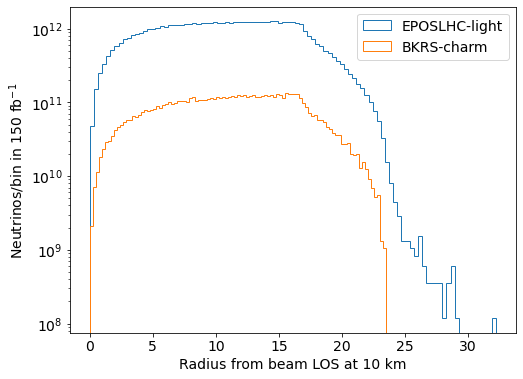

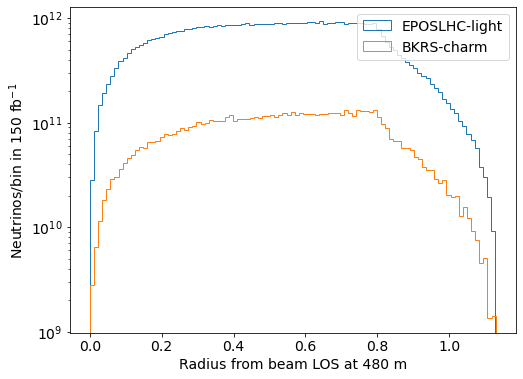

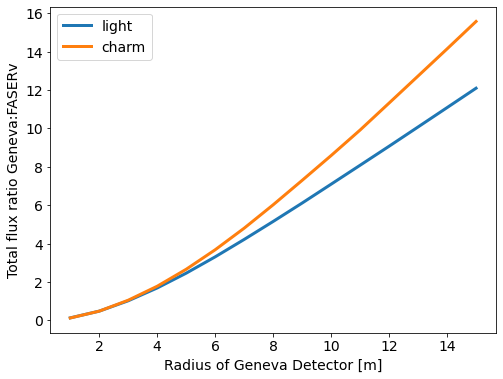

In [3]:
# angular_distribution(get_file('LHC13','SIBYLL','light'))
# position_distribution(get_file('LHC13','SIBYLL','light'))
# angular_distribution(get_file('Large','EPOSLHC','light'))
# position_distribution(get_file('Large','EPOSLHC','light'))
# angular_distribution(get_file('Large','BKRS','charm'))
# position_distribution(get_file('Large','BKRS','charm'))

# fig = plt.figure()
# ax1 = fig.add_subplot(111)
# pseudorapidity_distribution(get_file('LHC13','SIBYLL','light'),ax1)
# pseudorapidity_distribution(get_file('Large','EPOSLHC','light'),ax1)
# pseudorapidity_distribution(get_file('Large','BKRS','charm'),ax1)
# plt.legend()
# plt.semilogy()
# plt.show()

fig = plt.figure()
ax1 = fig.add_subplot(111)
#radial_distribution(get_file('LHC13','SIBYLL','light'),ax1,label='SIBYLL-light')
radial_distribution(get_file('Large','EPOSLHC','light'),ax1,label='EPOSLHC-light')
radial_distribution(get_file('Large','BKRS','charm'),ax1,label='BKRS-charm')
plt.xlabel('Radius from beam LOS at 10 km')
plt.ylabel(r'Neutrinos/bin in 150 fb$^{-1}$')
plt.legend()
plt.semilogy()
plt.show()
plt.close(fig)

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
#radial_distribution(get_file('LHC13','SIBYLL','light'),ax1,posz=480,label='SIBYLL-light')
radial_distribution(get_file('Large','EPOSLHC','light'),ax1,posz=480,label='EPOSLHC-light')
radial_distribution(get_file('Large','BKRS','charm'),ax1,posz=480,label='BKRS-charm')
plt.xlabel('Radius from beam LOS at 480 m')
plt.ylabel(r'Neutrinos/bin in 150 fb$^{-1}$')
plt.legend()
plt.semilogy()
plt.show()
plt.close(fig)

radius_arr = np.linspace(1,15,15)
ratio_arr = {}
ratio_arr['light'] = FluxRatio(get_file('Large','EPOSLHC','light'),'FASERv',radius_arr)
ratio_arr['charm'] = FluxRatio(get_file('Large','BKRS','charm'),'FASERv',radius_arr)
for k in ['light','charm']:
    plt.plot(radius_arr,ratio_arr[k],label=k)
plt.xlabel('Radius of Geneva Detector [m]')
plt.ylabel('Total flux ratio Geneva:FASERv')
plt.legend()
plt.show()